# **Basic Application [Training FMNIST with torch.nn.Linear] **

### **1. Retrieve the dataset using torchivision**

In [1]:
from torchvision import datasets
data_folder = '~/data/FMNIST'
# Training_Dataset
FMNIST = datasets.FashionMNIST(data_folder,download=True,train=True)
trn_images = FMNIST.data
trn_targets = FMNIST.targets
# Test_Dataset
val_FMNIST = datasets.FashionMNIST(data_folder,download=True,train=False) # Training is not needed as there will be no updates on the weights and biases for the evaluation
val_images = val_FMNIST.data
val_targets = val_FMNIST.targets

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



In [2]:
# Prerequisites
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### **2. Construct necessary functions to train the model**

In [3]:
trn_images.shape

torch.Size([60000, 28, 28])

In [4]:
# Build a model with two hidden layers
def build_model():
  model = nn.Sequential(
      nn.Linear(28*28,1000), # As shown above, the input size is 28x28. Hence, for the number of in-channels, 784 (28*28) should be inputted.
      nn.ReLU(),
      nn.Linear(1000,1000),
      nn.ReLU(),
      nn.Linear(1000,10)
  ).to(device) # if equipped with gpu, it allows for a faster computation
  loss_function = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(),lr=1e-3)
  return model, loss_function, optimizer

def train_model(x,y,model,loss_function,optimizer):
  model.train()
  prediction = model(x)
  l1_regularization = 0
  for param in model.parameters():
    l1_regularization += torch.norm(param,2)
  loss = loss_function(prediction,y) + 0.01*l1_regularization
  loss.backward() # Backpropagation
  optimizer.step()
  optimizer.zero_grad() # Ensures no acculmulation of weight values
  return loss.item()

@torch.no_grad() 
def accuracy(x,y,model):
  model.eval()
  prediction = model(x)
  max_vals, argmaxes = prediction.max(-1)
  acc = argmaxes == y
  return acc.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x,y,model,loss_function):
  prediction = model(x)
  val_loss = loss_function(prediction,y)
  return val_loss.item()

### **3. Convert the datasets to the dataloaders**

In [5]:
class FMNISTds(Dataset):
  def __init__(self,x,y):
    x = x.float()
    x = x.view(-1,28*28)/255 # changing the original dimension (28x28) to the one-line vector to enable 'nn.Linear' to work
    self.x, self.y = x, y
  def __len__(self): return len(self.x)
  def __getitem__(self,ix):
    x = self.x[ix]
    y = self.y[ix]
    return x.to(device), y.to(device)

def cvt2dl(): #Convert to DataLoader
  trn = FMNISTds(trn_images,trn_targets)
  trn_dl = DataLoader(trn,batch_size=32,shuffle=True,drop_last=True)

  val = FMNISTds(val_images,val_targets)
  val_dl = DataLoader(val,batch_size=len(val_images),shuffle=False,drop_last=True)
  return trn_dl, val_dl

In [6]:
# Call the necessary variables before building the epoch script
model, loss_function, optimizer = build_model()
trn_dl, val_dl = cvt2dl()

### **4. Training the model iteratively**

In [7]:
import torch.optim
# The variable below monitors the validation loss constantly and decrease the learning rate if the validation loss does not decrease.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.5,patience=0,
                                                       threshold=0.001,
                                                       verbose=True,
                                                       min_lr=1e-5,
                                                       threshold_mode='abs')
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
  print(f'{epoch+1}/10 in pregress')
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_model(x,y,model,loss_function,optimizer)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    trn_acc = accuracy(x,y,model)
    train_epoch_accuracies.extend(trn_acc)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_acc = accuracy(x,y,model)
    validation_loss = val_loss(x,y,model,loss_function)
    scheduler.step(validation_loss)
  val_epoch_accuracy = np.mean(val_acc)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)
                                                  

1/10 in pregress
2/10 in pregress
3/10 in pregress
Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.
4/10 in pregress
5/10 in pregress
Epoch 00005: reducing learning rate of group 0 to 2.5000e-04.
6/10 in pregress
7/10 in pregress
8/10 in pregress
Epoch 00008: reducing learning rate of group 0 to 1.2500e-04.
9/10 in pregress
10/10 in pregress
Epoch 00010: reducing learning rate of group 0 to 6.2500e-05.


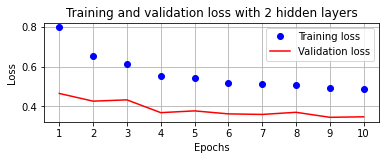

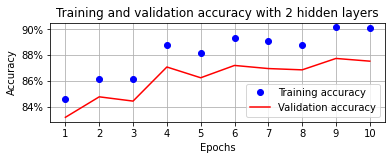

In [8]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 2 hidden layers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 2 hidden layers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()